# Load and View Data

Number of data points: 200
k in [0, 199]


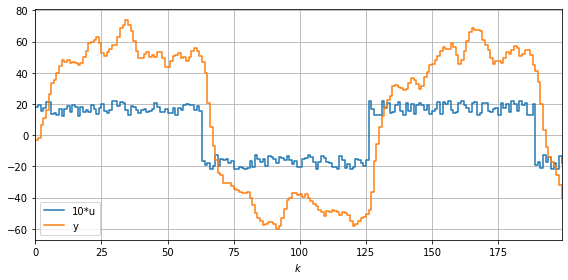

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='10*u', drawstyle='steps-post')
plt.plot(k, y   , label='y'   , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Input Fourier Transform

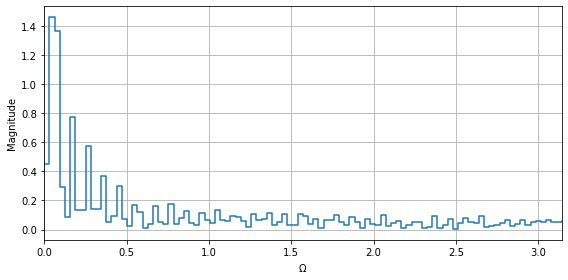

In [2]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.xlabel(r'$\Omega$')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [3]:
systems = pd.DataFrame(columns=['model', 'na', 'nb', 'nc', 'nd', 'nf', 'nk', 'A', 'B', 'C', 'D', 'F'])

# ARX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\end{gather*}

In [4]:
from pysid import arx

na_range = range(1, 3 + 1)
nb_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

systems_arx = pd.DataFrame()
for na in na_range:
  for nb in nb_range:
    for nk in nk_range:
      if nb-1 > na:
        continue

      id = arx(na=na, nb=nb-1, nk=nk, u=u, y=y)
      A = id.A[0][0]
      B = id.B[0][0]

      systems_arx = pd.concat([systems_arx, pd.DataFrame({
        'model': 'arx',
        'na': [na],
        'nb': [nb],
        'nk': [nk],
        'A': [A],
        'B': [B],
      })])

systems = pd.concat([systems, systems_arx])

# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

In [5]:
from pysid import armax

na_range = range(1, 3 + 1)
nb_range = range(1, 3 + 1)
nc_range = range(0, 3 + 1)
nk_range = range(0, 2 + 1)

systems_armax = pd.DataFrame()
for na in na_range:
  for nb in nb_range:
    for nc in nc_range:
      for nk in nk_range:
        if nb-1 > na:
          continue

        id = armax(na=na, nb=nb-1, nc=nc, nk=nk, u=u, y=y)
        A = id.A[0][0]
        B = id.B[0][0]
        C = id.C[0]

        systems_armax = pd.concat([systems_armax, pd.DataFrame({
          'model': 'armax',
          'na': [na],
          'nb': [nb],
          'nc': [nc],
          'nk': [nk],
          'A': [A],
          'B': [B],
          'C': [C],
        })])

systems = pd.concat([systems, systems_armax])

# Output Error

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [6]:
from pysid import oe

nb_range = range(1, 3 + 1)
nf_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

systems_oe= pd.DataFrame()
for nb in nb_range:
  for nf in nf_range:
    for nk in nk_range:
      if nb-1 > nf:
        continue

      id = oe(nb=nb-1, nf=nf, nk=nk, u=u, y=y)
      B = id.B[0][0]
      F = id.F[0][0]

      systems_oe = pd.concat([systems_oe, pd.DataFrame({
        'model': 'oe',
        'nb': [nb],
        'nf': [nf],
        'nk': [nk],
        'B': [B],
        'F': [F],
      })])

systems = pd.concat([systems, systems_oe])

# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [8]:
from pysid import bj

nb_range = range(1, 3 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(1, 3 + 1)
nf_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

systems_bj = pd.DataFrame()
for nb in nb_range:
  for nc in nc_range:
    for nd in nd_range:
      for nf in nf_range:
        for nk in nk_range:
          if nb-1 > na or nc > nd:
            continue

          try:
            id = bj(nb=nb-1, nc=nc, nd=nd, nf=nf, nk=nk, u=u, y=y)
            B = id.B[0][0]
            C = id.C[0]
            D = id.D[0]
            F = id.F[0][0]

            systems_bj = pd.concat([systems_bj, pd.DataFrame({
              'model': 'bj',
              'nb': [nb],
              'nc': [nc],
              'nd': [nd],
              'nf': [nf],
              'nk': [nk],
              'B': [B],
              'C': [C],
              'D': [D],
              'F': [F],
            })])
          except Exception as e:
            # display(str(e))
            systems_bj = pd.concat([systems_bj, pd.DataFrame({
              'model': 'bj',
              'nb': [nb],
              'nc': [nc],
              'nd': [nd],
              'nf': [nf],
              'nk': [nk],
            })])

systems = pd.concat([systems, systems_bj])

d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value